# Spectral maps

*spotter* can be used to model time series spectra of non-uniform stars. In this tutorial we showcase some of these features.

```{important}
The features shown in this tutotrial are still experimental and not tested against ground truth. Use with care!
```

## A simple spotted surface

We first create a surface with a single circular spot

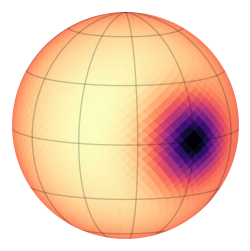

In [1]:
from spotter import Star
from spotter import core, show
import matplotlib.pyplot as plt

base_star = Star.from_sides(2**4, period=0.02, u=(0.2, 0.2), inc=1.4)
spot = core.soft_spot(base_star.sides, 0.0, 0.0, 0.15)

plt.figure(figsize=(3, 3))
show(base_star - spot, 0.63)

Here we will assume a stellar spectrum made of a single line with a Gaussian profile

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp


def gaussian(x, mu, sigma):
    return jnp.exp(-((x - mu) ** 2) / (2 * sigma**2))


wv = jnp.linspace(400, 410, 500) * 1e-9
star_spectrum = 1 - 0.5 * gaussian(wv, wv.mean(), 0.5e-9)

and we will assume that the star and its spot share the same spectrum. 

In *spotter*, we are in charge of setting the spectrum of each individual pixel. We do that by instantiating the [Star](spotter.star.Star) object with a spectral spatial map of shape *(wavelength, pixels)*

In [3]:
import warnings

warnings.filterwarnings("error")

spectra = star_spectrum[:, None] * (base_star - spot).y

star = base_star.set(y=spectra, wv=wv)
star.y.shape

(500, 3072)

This way, `star.y` holds the `len(wv)` spatial maps of the star. Here is a plot to realize what that means

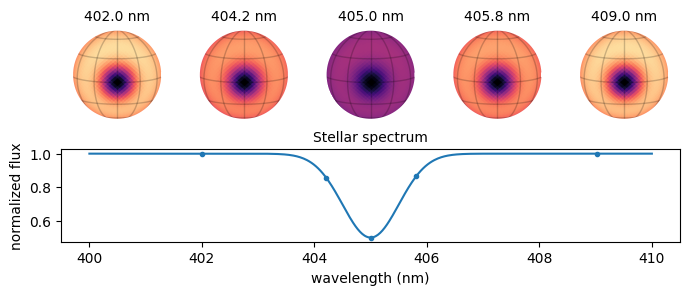

In [4]:
from matplotlib import gridspec

idxs = jnp.array([100, 210, 250, 290, 450])

fig = plt.figure(figsize=(7, 3))
axes = gridspec.GridSpec(2, len(idxs))
ax = plt.subplot(axes[1, :])
ax.plot(wv * 1e9, star_spectrum)
ax.plot(wv[idxs] * 1e9, star_spectrum[idxs], ".", c="C0")
ax.set_xlabel("wavelength (nm)")
ax.set_ylabel("normalized flux")
ax.set_title("Stellar spectrum", fontsize=10)

for i, idx in enumerate(idxs):
    ax = plt.subplot(axes[0, i])
    show(star[idx], vmax=1)
    ax.set_title(f"{wv[idx] * 1e9:.1f} nm", fontsize=10)

_ = plt.tight_layout()

In the last plot we used the fact that `star[i]` returns the star at the i-th wavelength.

From there we can compute the observed intensity of the star at a given time 

In [5]:
from spotter.doppler import spectrum

observed_spectrum = spectrum(star, 0.0)

Let's plot the observed spectrum at different phases

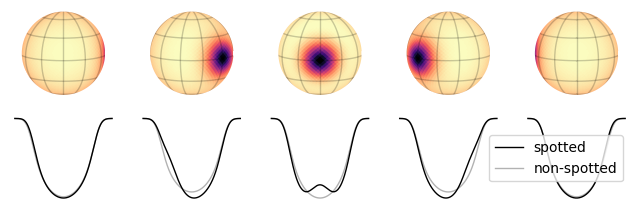

In [6]:
from spotter.doppler import spectrum

n = 5
fig, axes = plt.subplots(2, n, figsize=(8, 2.5))
nonspotted_spectrum = spectrum(star, star.period / 2)

for i, phase in enumerate(jnp.linspace(jnp.pi / 2, -jnp.pi / 2, n)):
    ax = axes[1, i]
    time = phase * star.period / (2 * jnp.pi)
    ax.plot(spectrum(star, time), c="k", lw=1, label="spotted")
    ax.plot(nonspotted_spectrum, "-", alpha=0.3, c="k", lw=1, label="non-spotted")
    ax.axis("off")

    ax = axes[0, i]
    show(star - spot, phase, ax=ax)

    if i == n - 1:
        plt.legend()

```{note}
In this example we used the same polynomial limb darkening coefficients across all wavelengths, which is not very realistic. The [Star.u](spotter.star.Star.u) argument also accept a set of (wavelength) limb darkening coefficients to be used at each wavelength.
```

## Spectral spatial maps

Because of their cooler temperatures (among other factors), starspots usually have their own spectra, different from the star's. Hence, in this section, we define the spectra of the star and the spot separately

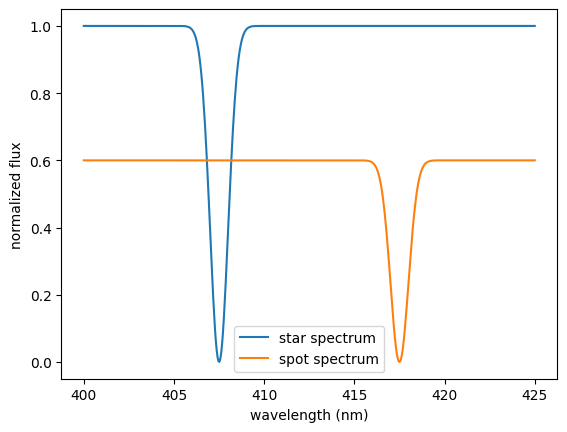

In [7]:
wv = jnp.linspace(400, 425, 500) * 1e-9
star_spectrum = 1 - gaussian(wv, wv.mean() - 0.2 * jnp.ptp(wv), 0.5e-9)
spot_spectrum = 0.6 * (1 - gaussian(wv, wv.mean() + 0.2 * jnp.ptp(wv), 0.5e-9))

plt.plot(wv * 1e9, star_spectrum, label="star spectrum")
plt.plot(wv * 1e9, spot_spectrum, label="spot spectrum")
plt.legend()
plt.xlabel("wavelength (nm)")
_ = plt.ylabel("normalized flux")

The next step consists in setting the spectra of each pixel in the map

In [8]:
import numpy as np

# setting the spectrum of the unspotted part of the star
spectra = (base_star.y - spot) * star_spectrum[:, None]

# setting the spectrum of the spotted part of the star
spectra = spectra + spot[None, :] * spot_spectrum[:, None]
star = base_star.set(y=spectra, wv=wv)

As in the previous example, here is the observed spectrum at different phases

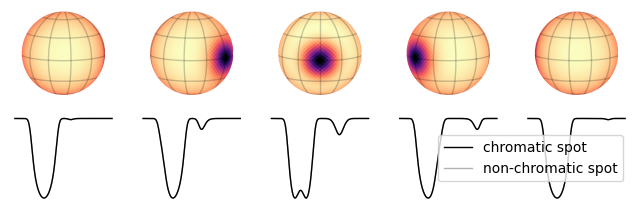

In [9]:
n = 5
fig, axes = plt.subplots(2, n, figsize=(8, 2.5))

for i, phase in enumerate(jnp.linspace(jnp.pi / 1.8, -jnp.pi / 1.8, n)):
    ax = axes[1, i]
    time = phase * star.period / (2 * jnp.pi)
    ax.plot(spectrum(star, time), c="k", lw=1, label="chromatic spot")
    ax.plot(
        spectrum(star, time),
        c="k",
        lw=1,
        alpha=0.3,
        label="non-chromatic spot",
    )
    ax.axis("off")

    ax = axes[0, i]
    show(base_star - spot, phase, ax=ax)

    if i == n - 1:
        plt.legend()